# Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne — wymiar funkcji, której minimum szukamy, może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to `[0, 1]`, to `135` sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństwo mutacji i zmienia wartość jednego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie — z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały algorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować). Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [3]:
class Chromosome:
    def __init__(
        self, length, array=None
    ):  # if array is None it should be initialized with random binary vector
        if array is None:
            array = np.random.choice([True, False], length)
        assert len(array) == length
        self.array = array
        self.length = length

    def decode(self, lower_bound, upper_bound, aoi):
        size = upper_bound - lower_bound
        powers_of_2 = np.array([2**i for i in range(size)])
        num = np.sum(np.dot(self.array[lower_bound:upper_bound], powers_of_2))
        # opcjonalnie kod graya - brak róznicy w wynikach (dla obecnych parametrów)
        # if True:
        #     mask = num
        #     while mask != 0:
        #         mask >>= 1
        #         num ^= mask
        num_min = 0
        num_max = 2**size - 1
        return min_max_norm(num, num_min, num_max, aoi[0], aoi[1])

    def mutation(self, probability):
        if np.random.random() <= probability:
            i = np.random.randint(0, len(self.array))
            self.array[i] = not self.array[i]

    def crossover(self, other):
        assert len(self.array) == len(other.array)
        i = np.random.randint(0, len(self.array))
        a = np.append(self.array[:i], other.array[i:])
        b = np.append(other.array[:i], self.array[i:])
        self.array = a
        other.array = b

In [4]:
from matplotlib.pyplot import hist


def plot_func(trace, func, x_min=-2, x_max=3, y_min=-4, y_max=2):
    xs = np.arange(x_min, x_max, 0.05)
    ys = np.arange(y_min, y_max, 0.05)
    xs, ys = np.meshgrid(xs, ys)
    zs = func(xs, ys)
    plt.figure()
    plt.contour(xs, ys, zs, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()


class GeneticAlgorithm:
    def __init__(
        self,
        chromosome_length,
        obj_func_num_args,
        objective_function,
        aoi,
        population_size=1000,
        tournament_size=2,
        mutation_probability=0.05,
        crossover_probability=0.8,
        num_steps=30,
    ):
        assert (
            chromosome_length % obj_func_num_args == 0
        ), "Number of bits for each argument should be equal"
        self.chromosome_length = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps
        self.population = [
            Chromosome(self.chromosome_length) for _ in range(population_size)
        ]

    def eval_objective_func(self, chromosome):
        values = [
            chromosome.decode(
                self.bits_per_arg * i, self.bits_per_arg * (i + 1), self.aoi
            )
            for i in range(self.obj_func_num_args)
        ]
        return self.objective_function(*values)

    def tournament_selection(self):
        chosen = []
        for _ in range(len(self.population)):
            picks = np.random.choice(self.population, self.tournament_size)
            best = min(picks, key=lambda c: self.eval_objective_func(c))
            chosen.append(copy.deepcopy(best))
        return chosen

    def reproduce(self, parents):
        new_pop = []
        for i in range(len(parents) // 2):
            # after selection the population is already in random order
            a, b = parents[2 * i], parents[2 * i + 1]
            if np.random.random() <= self.crossover_probability:
                a.crossover(b)
            new_pop.extend([a, b])
        return new_pop

    def run(self):
        best = []
        for t in range(self.num_steps):
            self.population = self.tournament_selection()
            self.population = self.reproduce(self.population)
            for chromosome in self.population:
                chromosome.mutation(self.mutation_probability)
            current_best = min(
                self.population, key=lambda c: self.eval_objective_func(c)
            )
            best.append(copy.deepcopy(current_best))
        return best

In [5]:
def f(x, y):
    return (
        1.5 - np.exp(-(x**2) - y**2) - 0.5 * np.exp(-((x - 1) ** 2) - (y + 2) ** 2)
    )

In [6]:
def test_case(func, x_range=(-5, 5), y_range=(-5, 5), **kwargs):
    ga = GeneticAlgorithm(
        chromosome_length=64,
        obj_func_num_args=2,
        objective_function=f,
        aoi=(-5, 5),
        population_size=20,
        num_steps=500,
        **kwargs
    )
    best = ga.run()
    trace = []
    for h in best:
        x = h.decode(0, ga.bits_per_arg, ga.aoi)
        y = h.decode(ga.bits_per_arg, 2 * ga.bits_per_arg, ga.aoi)
        trace.append([x, y])
    plot_func(
        trace,
        func,
        x_min=x_range[0],
        x_max=x_range[1],
        y_min=y_range[0],
        y_max=y_range[1],
    )

In [7]:
def visualize_func(func):
    xs = np.arange(-5, 5, 0.1)
    ys = np.arange(-5, 5, 0.1)
    xs, ys = np.meshgrid(xs, ys)
    zs = func(xs, ys)
    data = []
    data.append(go.Surface(x=xs, y=ys, z=zs, colorscale="viridis"))
    fig = go.Figure(data=data)
    fig.update_layout(height=600, autosize=True)
    fig.show()
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(xs, ys, zs, cmap=plt.cm.viridis)
    # plt.show()

In [8]:
visualize_func(f)

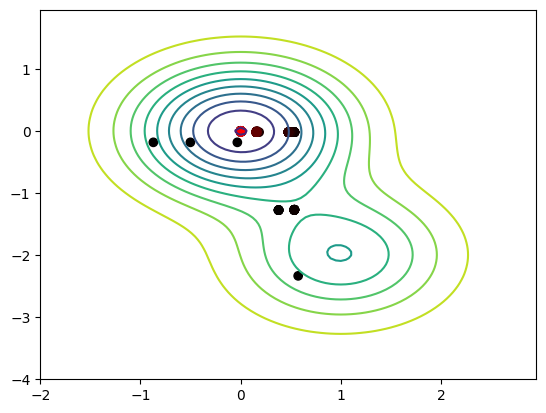

In [9]:
test_case(f, x_range=(-2, 3), y_range=(-4, 2))

Możemy zauważyć, że algorytm zawsze znajduje minimum globalne, w przeciwieństwie do metody gradientowej, w której zależało to od punktu startowego. Najlepsze punkty nie tworzą też lini prostej, ale losowo zbliżają się to środka. Wiąże się to jednak z dużo większą liczbą ewaluacji funkcji.

In [10]:
# https://en.wikipedia.org/wiki/Ackley_function
def ackley(x, y):
    return (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e
        + 20
    )

In [11]:
visualize_func(ackley)

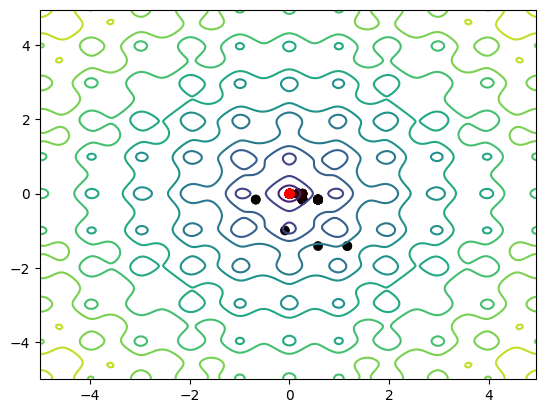

In [12]:
test_case(ackley)

In [13]:
# https://en.wikipedia.org/wiki/Rastrigin_function
def rastrigin(x, y):
    return (
        20 + x**2 - 10 * np.cos(2 * np.pi * x) + y**2 - 10 * np.cos(2 * np.pi * y)
    )

In [14]:
visualize_func(rastrigin)

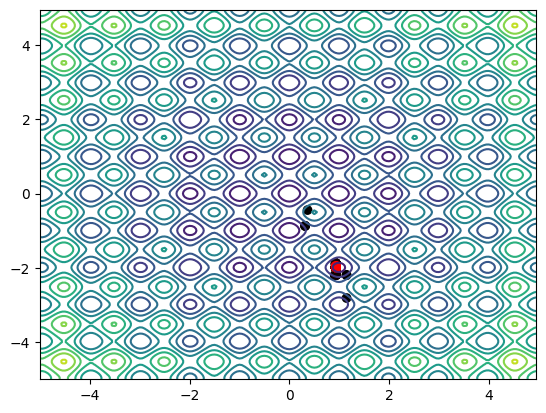

In [15]:
test_case(rastrigin)